In [1]:
import re
import os
import sys
import glob
import time
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime

from matplotlib.colors import LogNorm

import peakutils

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/')#('/global/homes/r/romo/repos/BACON_romo/')
sys.path.append(repository_path)

import fit_functions as fitf

In [3]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/' #NERSC: /pscratch/sd/r/romo/bacon_data_npz/

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 50

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

In [4]:
### Gains to calibrate the channels
## With the trigger channels it depends on the date because there were more variations

gains_all_chs = {0: (142.951, 5.925),
                 1: (132.500, -3.333),
                 2: (135.502, 12.886),
                 3: (135.000, -5.000),
                 4: (143.315,  5.262),
                 5: (137.660, 11.814),
                 6: (130.000, 0.),
                 7: (138.123, 12.840),
                 8: (131.772, 13.920),
                 9: {'09_10_2024': (713.445, -20.038), 
                     '09_11_2024': (716.176, -19.673), 
                     '09_12_2024': (719.783, -10.151), 
                     '09_20_2024': (722.221, -11.124), 
                     '09_25_2024': (723.042, -11.830), 
                     '09_28_2024': (721.611, -12.276), 
                     '10_04_2024': (720.181, -12.722), 
                     '10_11_2024': (725.152, -12.032), 
                     '10_17_2024': (728.640, -11.851), 
                     '10_25_2024': (722.907, -12.550), 
                     '11_01_2024': (724.566, -11.215), 
                     '11_11_2024': (714.408, -12.857), 
                     '11_25_2024': (704.251, -14.499), 
                     '12_13_2024': (691.857,   2.794), 
                     '12_21_2024': (680.420,  -3.534), 
                     '01_02_2025': (671.088,   4.511), 
                     '01_10_2025': (703.052,   0.083), 
                     '01_19_2025': (707.833,  -5.059)},
                 
                 10: {'09_10_2024': (707.800, 43.580), 
                      '09_11_2024': (707.968, 44.407), 
                      '09_12_2024': (706.610, 45.092), 
                      '09_20_2024': (703.655, 53.165), 
                      '09_25_2024': (703.754, 53.722), 
                      '09_28_2024': (704.139, 52.949), 
                      '10_04_2024': (705.643, 52.823), 
                      '10_11_2024': (706.706, 53.208), 
                      '10_17_2024': (707.740, 53.039), 
                      '10_25_2024': (707.276, 53.987), 
                      '11_01_2024': (705.825, 54.078), 
                      '11_11_2024': (705.377, 53.354), 
                      '11_25_2024': (705.761, 52.763), 
                      '12_13_2024': (709.026, 53.851), 
                      '12_21_2024': (709.094, 55.053), 
                      '01_02_2025': (709.721, 55.118), 
                      '01_10_2025': (710.348, 55.183), 
                      '01_19_2025': (711.481, 54.422)},
                 
                 11: {'09_10_2024': (641.030, 48.974), 
                      '09_11_2024': (642.714, 47.617), 
                      '09_12_2024': (645.527, 48.325), 
                      '09_20_2024': (648.580, 45.411), 
                      '09_25_2024': (651.633, 42.497), 
                      '09_28_2024': (651.651, 42.437), 
                      '10_04_2024': (652.104, 42.815), 
                      '10_11_2024': (652.307, 42.757), 
                      '10_17_2024': (652.510, 42.698), 
                      '10_25_2024': (641.258, 60.174), 
                      '11_01_2024': (647.961, 51.403), 
                      '11_11_2024': (654.665, 42.632), 
                      '11_25_2024': (656.109, 43.477), 
                      '12_13_2024': (656.052, 44.115), 
                      '12_21_2024': (655.995, 44.754), 
                      '01_02_2025': (655.938, 45.393), 
                      '01_10_2025': (655.881, 46.032), 
                      '01_19_2025': (656.365, 44.774)}}

In [5]:
num_files_to_analyze = 50

start_time = time.time()

filt_evts_dict = {}
idx_max        = {}
height_sg      = {}

trigg_evts_dict = {}
idx_max_trigg   = {}
height_sg_trigg = {}

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files[:num_files_to_analyze]):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_dict:
        print(date)
        filt_evts_dict[date] = {ch: d['filt_evts_dict'] .item()[ch] for ch in normal_chs}
        idx_max       [date] = {ch: d['idx_peaks_max']  .item()[ch] for ch in normal_chs}
        height_sg     [date] = {ch: (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0] for ch in normal_chs}
    else:
        for ch in normal_chs:
            try:
                filt_evts_dict[date][ch] = np.concatenate((filt_evts_dict[date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                idx_max       [date][ch] = np.concatenate((idx_max       [date][ch], d['idx_peaks_max']  .item()[ch]))
                height_sg     [date][ch] = np.concatenate((height_sg     [date][ch], (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue

                
    if date not in idx_max_trigg:
        print(date)
        trigg_evts_dict[date] = {ch: np.arange(len(d['idx_peaks_max_trigg'].item()[9])) for ch in trigger_chs}
        idx_max_trigg  [date] = {ch: d['idx_peaks_max_trigg']   .item()[ch] for ch in trigger_chs}
        height_sg_trigg[date] = {ch: (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0] for ch in trigger_chs}
    else:
        for ch in trigger_chs:
            try:
                trigg_evts_dict[date][ch] = np.concatenate((trigg_evts_dict[date][ch], adapt_evt_id(np.arange(len(d['idx_peaks_max_trigg'].item()[9])), fnum)))
                idx_max_trigg  [date][ch] = np.concatenate((idx_max_trigg  [date][ch], d['idx_peaks_max_trigg']  .item()[ch]))
                height_sg_trigg[date][ch] = np.concatenate((height_sg_trigg[date][ch], (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_10_2024
09_11_2024
09_11_2024
20
40
09_12_2024
09_12_2024
Elapsed time: 31.781198024749756 s, 0.5296866337458292 min


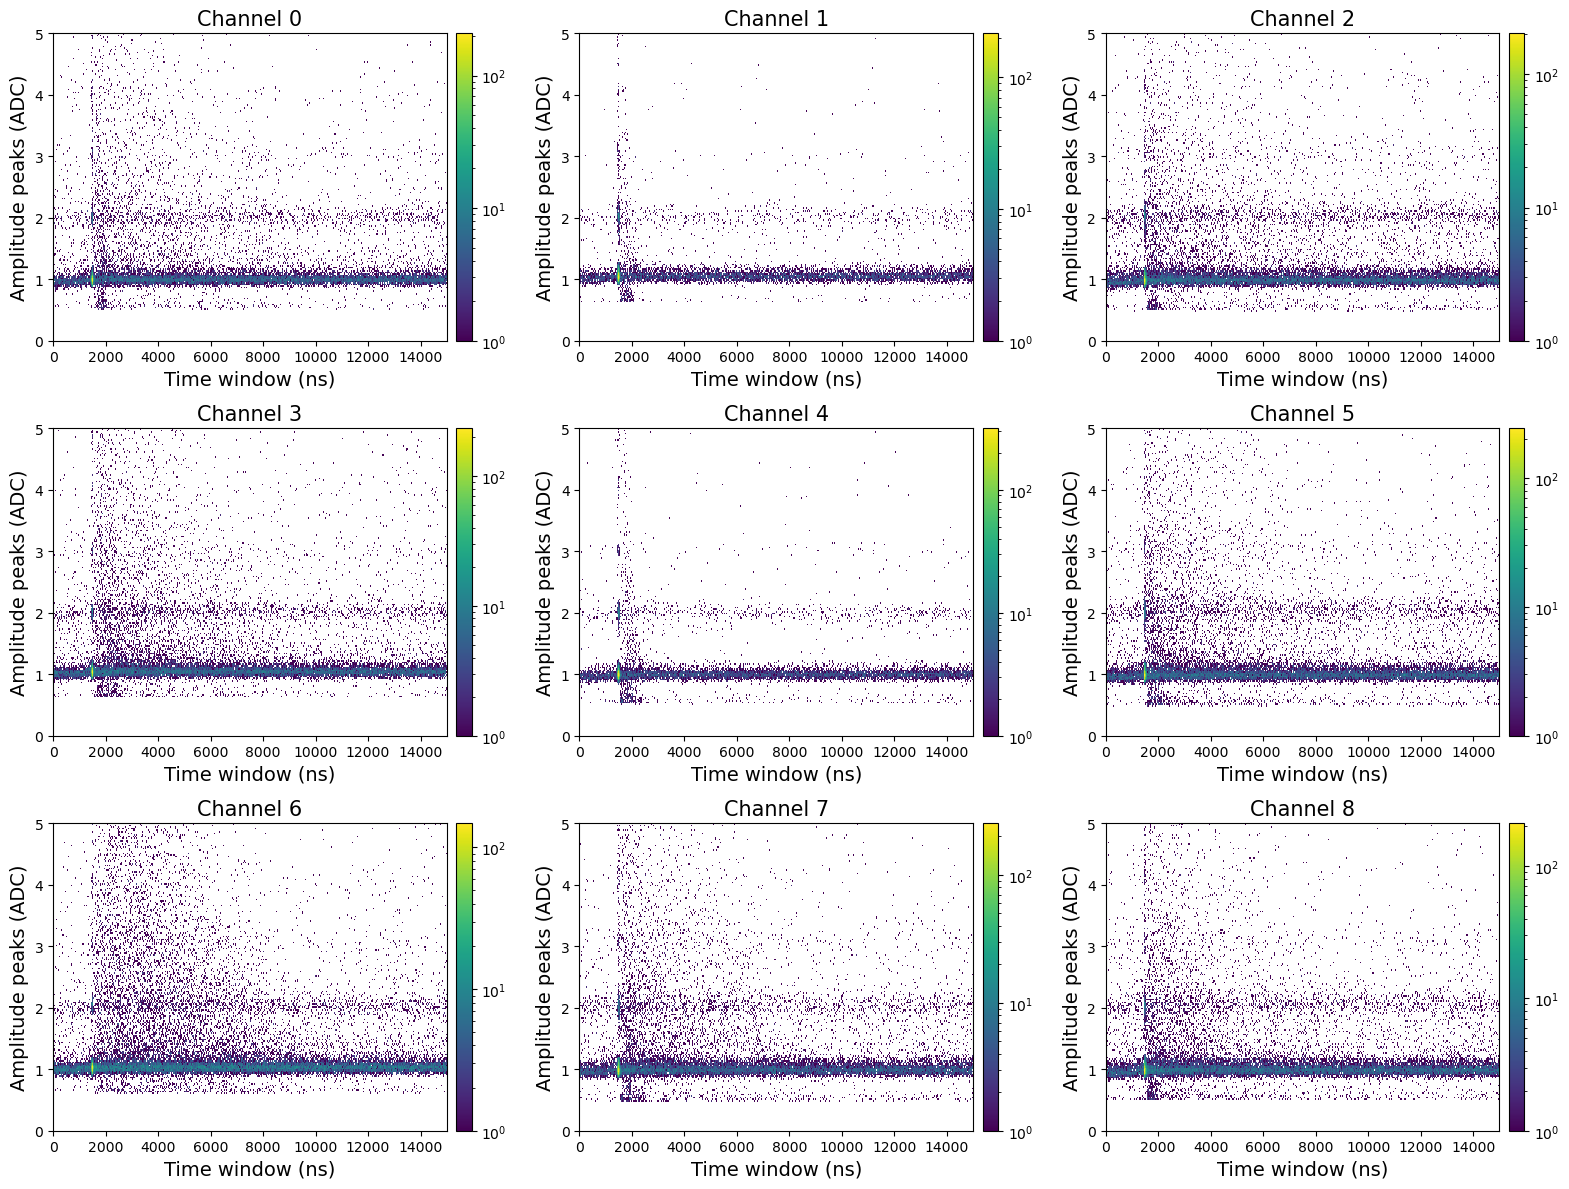

In [6]:
sel_dates = idx_max.keys()
fig, axs  = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    try:
        ch_idxs = np.concatenate([np.concatenate(idx_max  [date][ch]) for date in sel_dates])
        ch_vals = np.concatenate([np.concatenate(height_sg[date][ch]) for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 5)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
plt.show()

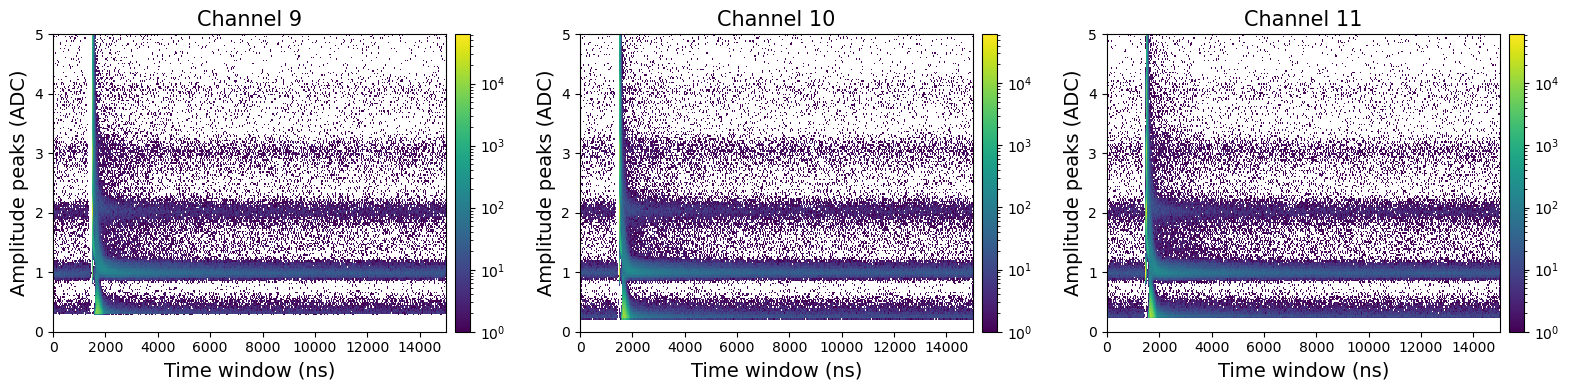

In [7]:
sel_dates = idx_max_trigg.keys()
fig, axs  = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([np.concatenate(idx_max_trigg  [date][ch]) for date in sel_dates])
        ch_vals = np.concatenate([np.concatenate(height_sg_trigg[date][ch]) for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 5)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
plt.show()

## Convert to  pandas df

In [8]:
data_for_df = {'date': [],
               'evt':  []}
data_for_df.update({f'ch{ch}_idx':    [] for ch in range(12)})
data_for_df.update({f'ch{ch}_height': [] for ch in range(12)})

for date in idx_max_trigg.keys():
    print(date)
    if date!='09_10_2024': #Choose a date to avoid loeading all data
        continue
    for evt_id, idx9, height9, idx10, height10, idx11, height11 in zip(trigg_evts_dict[date][9],
                                                             idx_max_trigg[date][9],  height_sg_trigg[date][9],
                                                             idx_max_trigg[date][10], height_sg_trigg[date][10],
                                                             idx_max_trigg[date][11], height_sg_trigg[date][11]):
        data_for_df['date']       .append(date)
        data_for_df['evt']        .append(evt_id)
        data_for_df['ch9_idx']    .append(idx9)
        data_for_df['ch9_height'] .append(height9)
        data_for_df['ch10_idx']   .append(idx10)
        data_for_df['ch10_height'].append(height10)
        data_for_df['ch11_idx']   .append(idx11)
        data_for_df['ch11_height'].append(height11)
        
        for ch in normal_chs:
            if evt_id in filt_evts_dict[date][ch]:
                data_for_df[f'ch{ch}_idx']   .append(idx_max  [date][ch][np.where(filt_evts_dict[date][ch]==evt_id)[0][0]])
                data_for_df[f'ch{ch}_height'].append(height_sg[date][ch][np.where(filt_evts_dict[date][ch]==evt_id)[0][0]])
            else:
                data_for_df[f'ch{ch}_idx']   .append(None)
                data_for_df[f'ch{ch}_height'].append(None)
        
df = pd.DataFrame(data_for_df)

09_10_2024
09_11_2024
09_12_2024


In [9]:
df.head()

,date,evt,ch0_idx,ch1_idx,ch2_idx,ch3_idx,ch4_idx,ch5_idx,ch6_idx,ch7_idx,...,ch2_height,ch3_height,ch4_height,ch5_height,ch6_height,ch7_height,ch8_height,ch9_height,ch10_height,ch11_height
0,09_10_2024,0,[4683],None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,"[1.8612902973087708, 0.3195293907358944]","[1.054059906049037, 1.0976301379044158, 0.2959...","[3.1706040268611133, 0.41261997922122035]"
1,09_10_2024,1,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,"[1.161061222903913, 1.3036309941199162]","[1.4253450572780444, 0.33138554404092146]",[1.098802119035129]
2,09_10_2024,2,None,None,None,[4408],None,None,None,None,...,None,[1.0126710419210119],None,None,None,None,None,"[2.0152293742998757, 1.911744838763737, 0.3145...",[1.7908677533884059],"[2.108171314466263, 0.3285524992992089]"
3,09_10_2024,3,None,None,None,None,[516],None,None,None,...,None,None,[1.0336105424657498],None,None,None,None,[3.1537070019470885],"[4.825240753517722, 0.30334679608305276]","[2.8643761621853128, 0.46590402801631137]"
4,09_10_2024,4,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,[1.7984617771295972],"[2.0637022975354293, 0.26085607998119914]","[1.942747153922448, 0.27936459835974375]"
